### Required Imports

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import os
import plotly
import plotly.graph_objs as go
import time
import itertools
import cv2
import seaborn as sns
import warnings
import tqdm
import math


%matplotlib inline
plotly.offline.init_notebook_mode(True)

dataset_dir = '../input/'
meta_info = os.path.join(dataset_dir, 'Meta.csv')
train_csv_path = os.path.join(dataset_dir, 'Train.csv')
test_csv_path = os.path.join(dataset_dir, 'Test.csv')
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

### Load data


In [2]:
train_data_color = '#073d47'
test_data_color = '#823ea4'

trainDf = pd.read_csv(train_csv_path)
testDf = pd.read_csv(test_csv_path)
metaDf = pd.read_csv(meta_info)

trainDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), trainDf['Path']))
testDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), testDf['Path']))
metaDf['Path'] = list(map(lambda x: os.path.join(dataset_dir,x.lower()), metaDf['Path']))

trainDf.sample(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
8296,39,41,5,6,34,36,4,../input/train/4/00004_00061_00016.png
25933,39,40,6,6,34,35,18,../input/train/18/00018_00012_00013.png
36955,85,84,8,7,78,77,38,../input/train/38/00038_00031_00026.png


### Discover dataset balance
The easiest way to discover dataset balance - build histogram. We consider to use [seaborn](https://seaborn.pydata.org/) library based on matplotlib for pretty data visualization.

Train and test subset of dataset have similar balance distribution. Train and test split provided by GTSRB.

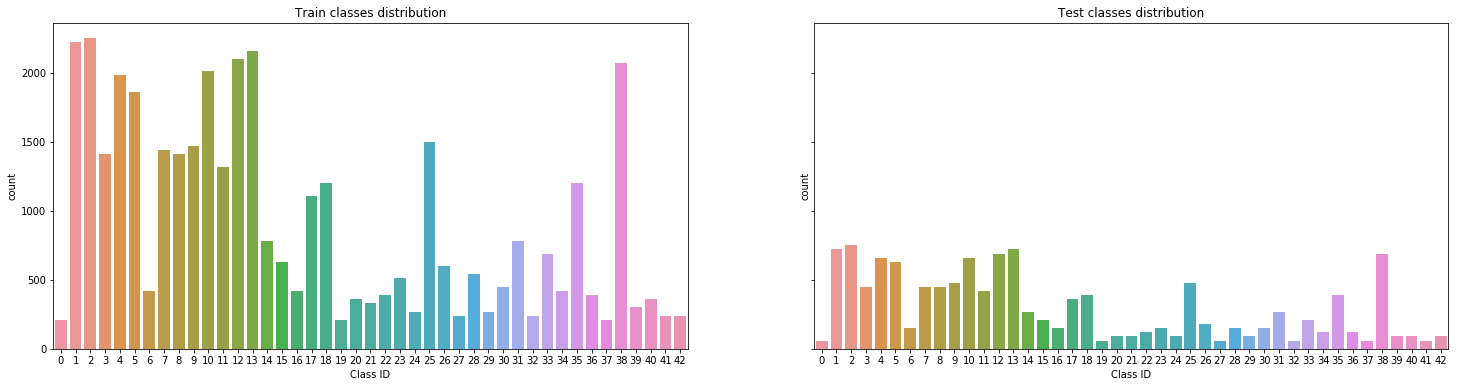

In [3]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(trainDf.ClassId, ax=axs[0])
sns.countplot(testDf.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

**Target class visualization**


It is not a sample in the dataset, it is just a picture of sign. Some of them may be different from the dataset samples because of dataset contains images of German traffic signs and pictures bellow are Ukrainian traffic signs [pictures source](http://pdd.ua/33/)

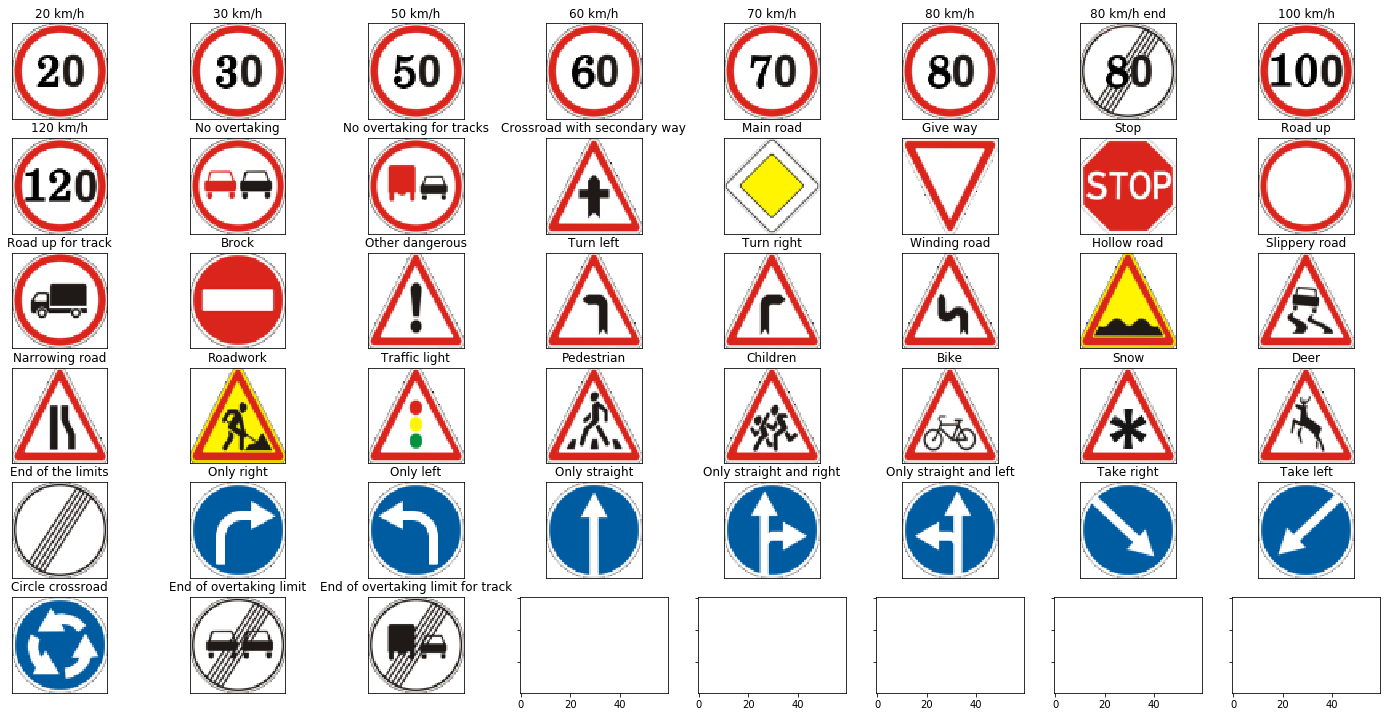

In [4]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
metaDf = metaDf.sort_values(by=['ClassId'])

idx = 0
for i in range(rows):
    for j in range(cols):
        if idx > 42:
            break
            
        img = cv2.imread(metaDf["Path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
        img[np.where(img[:,:,3]==0)] = [255,255,255,255]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        
        axs[i,j].imshow(img)
        axs[i,j].set_facecolor('xkcd:salmon')
        axs[i,j].set_facecolor((1.0, 0.47, 0.42))
        axs[i,j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

**Target Result **

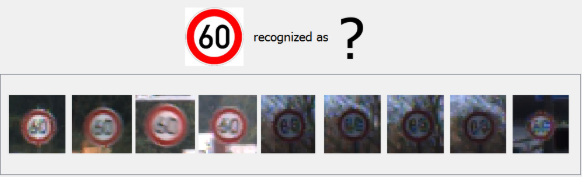


### Samples visualization

It is good idea to visualize samples in order to brief data exploration. Image visualization can help to understand data problem. Some solutions (such as histogram equalization) can be discovered by visual data exploration

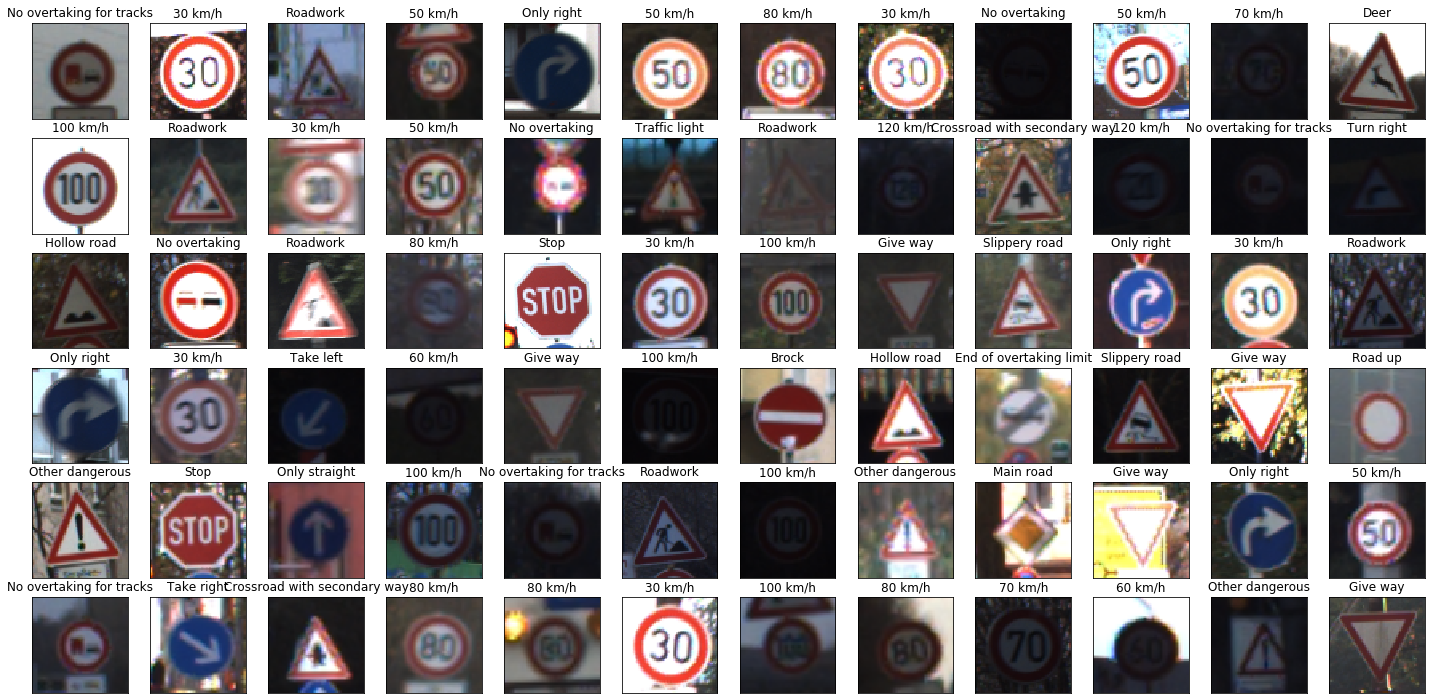

In [5]:
rows = 6
cols = 12
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=None)
visualize = trainDf.sample(rows*cols)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(visualize["Path"].tolist()[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60,60))
        axs[i,j].imshow(img)
        axs[i,j].set_title(labels[int(visualize["ClassId"].tolist()[idx])])
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1

### Tensorflow utils

Here we defined utils for loading tensors, augmentation and other data manipulation

In [6]:
img_load_size = (60,60)
zero_img = np.zeros([12,img_load_size[0], img_load_size[1], 3])
zero_label = np.zeros([12,1])


''' The parse_function will do the following:

read the content of the file
decode using jpeg format
convert to float values in [0, 1]
resize to size (64, 64) ''' 

def parse_function(filename, label):
    
        image_string = tf.read_file(filename)
        image = tf.image.decode_jpeg(image_string, channels=3)
        image.set_shape([None, None, 3])
        
        return filename, image, label    
    
def train_preprocess(filename, image, label):
    '''  train_preprocess can be used during training to perform data augmentation:

                 *Horizontally flip the image with probability 1/2
                 *Apply random brightness and saturation
    '''
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_images(image, img_load_size)
    return filename, image, label

def augmentate(filename, image, label):
    
    '''
    The amount of data we have is not sufficient for a model to generalise well.
    It is also fairly unbalanced, and some classes are represented to significantly lower extent than the others.
    But we will fix this with data augmentation
    * Flipping
    * Rotation and projection
    '''
    
    grad = tf.random.uniform(shape=[], minval=-0.3, maxval=0.3)
    dx = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    dy = tf.random.uniform(shape=[], minval=-15, maxval=15, dtype=tf.int32)
    image = tf.contrib.image.rotate(image, grad)
    image = tf.contrib.image.translate(image, translations=[dx, dy])
    
    return filename, image, label

def eq(img: np.ndarray):
    res = img.copy()
    res[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    res[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    res[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
    return res

def tf_equalize_histogram(image):
    
    ''' Histogram Equalization is a computer image processing technique used to improve contrast in images.
    It accomplishes this by effectively spreading out the most frequent intensity values,
                                     i.e. stretching out the intensity range of the image
    '''
    
    values_range = tf.constant([0., 255.], dtype = tf.float32)
    histogram = tf.histogram_fixed_width(tf.to_float(image), values_range, 256)
    cdf = tf.cumsum(histogram)
    cdf_min = cdf[tf.reduce_min(tf.where(tf.greater(cdf, 0)))]

    img_shape = tf.shape(image)
    pix_cnt = img_shape[-3] * img_shape[-2]
    px_map = tf.round(tf.to_float(cdf - cdf_min) * 255. / tf.to_float(pix_cnt - 1))
    px_map = tf.cast(px_map, tf.uint8)

    gth = tf.gather_nd(px_map, tf.cast(image, tf.int32))
    eq_hist = tf.expand_dims(gth, 2)
    return image

### Tensorflow data pipeline

We decide to use native tensorflow as deep learning framework without high level API. The best way to implement data pipleline - implement load data operation as node of computation graph. This will be the first node of computitional graph (i.e. all other node is depended from it). This approach has several advantages:

* Parallelism out of the box (provided by dataflow graph principies)
* Opportunity to implement data augmentation on GPU 
* Convenient way to wrok with it provided by tf.data infrastructure



In [14]:
tf.reset_default_graph()

epochs = 15
batch_size = 12
prefetch_count = 1
samples_train = len(trainDf)
samples_test = len(testDf)

dataset_train = tf.data.Dataset.from_tensor_slices((trainDf['Path'], trainDf['ClassId']))
dataset_train = dataset_train.shuffle(len(trainDf['Path']))
dataset_train = dataset_train.repeat(epochs)
dataset_train = dataset_train.map(parse_function, num_parallel_calls=4)
dataset_train = dataset_train.map(train_preprocess, num_parallel_calls=4)
dataset_train = dataset_train.map(augmentate, num_parallel_calls=4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(prefetch_count)

dataset_iterator = tf.data.Iterator.from_structure(dataset_train.output_types,
                                                          dataset_train.output_shapes)


dataset_test = tf.data.Dataset.from_tensor_slices((testDf['Path'], testDf['ClassId']))
dataset_test = dataset_test.shuffle(len(testDf['Path']))
dataset_test = dataset_test.repeat(epochs+1)
dataset_test = dataset_test.map(parse_function, num_parallel_calls=4)
dataset_test = dataset_test.map(train_preprocess, num_parallel_calls=4)
dataset_test = dataset_test.batch(batch_size)
dataset_test = dataset_test.prefetch(prefetch_count)


train_init_op = dataset_iterator.make_initializer(dataset_train)
test_init_op = dataset_iterator.make_initializer(dataset_test)

load_filename, load_img, load_label = dataset_iterator.get_next()

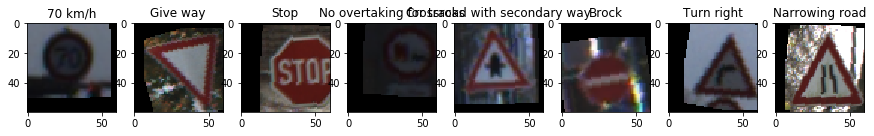

In [11]:
fig, ax = plt.subplots(ncols=8, nrows=1, figsize=(15, 6))
with tf.Session() as sess:
    sess.run(train_init_op)
    for j in range(8):
        i, l = sess.run([load_img, load_label])
        i = (i[0]*255).astype(np.uint8)
        ax[j].imshow(i)
        ax[j].set_title(labels[l[0]])

### Model definition



In [15]:
dp_rate = tf.placeholder(dtype=tf.float32, shape=[], name='dp_rate')

img_placeholder = tf.placeholder(shape=[None, 60,60,3], dtype=tf.float32, name='img_placeholder')
label_placeholder = tf.placeholder(shape=[None, 1], dtype=tf.int64, name='label_placeholder')
manual_load = tf.placeholder(dtype=tf.bool, shape=[], name='manual_load_placeholder')

# inp = net = tf.cond(pred=manual_load, true_fn=lambda : img_placeholder, false_fn=lambda : load_img, name='network_start')
# label = tf.cond(pred=manual_load, true_fn=lambda : label_placeholder, false_fn=lambda : load_label, name='label')

inp = net = tf.cond(manual_load, lambda: img_placeholder, lambda: load_img)
label = load_label

conv1 = net = tf.layers.conv2d(inputs=net, filters=16, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv2 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

conv3 = net = tf.layers.conv2d(inputs=net, filters=32, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv4 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

net = tf.layers.max_pooling2d(inputs=net, pool_size=(2,2), strides=(2,2))

conv5 = net = tf.layers.conv2d(inputs=net, filters=64, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=128, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

conv5 = net = tf.layers.conv2d(inputs=net, filters=256, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)
conv6 = net = tf.layers.conv2d(inputs=net, filters=400, kernel_size=(3,3), strides=(1,1), activation=tf.nn.leaky_relu)
net = tf.layers.batch_normalization(inputs=net)

flatten1 = net = tf.layers.flatten(inputs=net)

dp1 = net = tf.layers.dropout(inputs=net, rate=dp_rate)
dense1 = net = tf.layers.dense(inputs=net, units=256)
logits = tf.layers.dense(inputs=net, units=43)

pred_classes = tf.argmax(logits, axis=1)
pred_probas = tf.nn.softmax(logits)

acc, acc_op = tf.metrics.accuracy(labels=label, predictions=pred_classes)
end_loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=label)

loss = end_loss

label_transpose = tf.transpose(label)
correct_prediction = tf.equal(pred_classes, label_transpose)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
confusion_matrix_op = tf.confusion_matrix(labels=label, predictions=pred_classes, num_classes=43)

opt = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

### Model training

Train model several epoch and store results of each epoch for further analysis

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
train_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
best_acc = 0

for e in range(epochs):
    epoch_history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    
    sess.run(train_init_op)
    for i in tqdm.tqdm_notebook(range(samples_train//batch_size), ascii=True, desc='Train epoch {}'.format(e)):
        _, _loss, _acc, mn = sess.run([opt, loss, accuracy, inp], feed_dict={dp_rate: 0.3, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
#         print(np.mean(mn))
        epoch_history['loss'].append(_loss)
        epoch_history['acc'].append(_acc)
        
    sess.run(test_init_op)
    for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test epoch {}'.format(e)):
        _loss, _acc = sess.run([loss, accuracy], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
        epoch_history['val_loss'].append(_loss)
        epoch_history['val_acc'].append(_acc)
        
    train_history['loss'].append(np.mean(epoch_history['loss']))
    train_history['acc'].append(np.mean(epoch_history['acc']))
    train_history['val_loss'].append(np.mean(epoch_history['val_loss']))
    train_history['val_acc'].append(np.mean(epoch_history['val_acc']))
    
    print("***EPOCH SUMMARY*** Loss: {} Acc: {} | Test Loss: {} Test Acc {}".format(train_history['loss'][-1], train_history['acc'][-1],
                                                                                    train_history['val_loss'][-1], train_history['val_acc'][-1]))

    if train_history['val_acc'][-1] > best_acc:
        best_acc = train_history['val_acc'][-1]
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)

### Training result


In [ ]:
titlefont = dict(family='Courier New, monospace', size=18, color='#7f7f7f')
layout = go.Layout(title='Training & Test loss', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Loss', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['loss'], name='Train loss'), go.Scatter(y=train_history['val_loss'], name='Test loss')], layout=layout)
plotly.offline.iplot(fig)

layout = go.Layout(title='Training & Test accuracy', xaxis=dict(title='Epoch', titlefont=titlefont),
                                    yaxis=dict(title='Accuracy', titlefont=titlefont))
fig = go.Figure(data=[go.Scatter(y=train_history['acc'], name='Train accuracy'), go.Scatter(y=train_history['val_acc'], name='Test accuracy')], layout=layout)
plotly.offline.iplot(fig)

### Model performance data preparation

For futher model analysis we need some data. Very good solution - store all statistic data in pandas DataFrame data structure. Let's evaluate all test samples and store all information about prediction, probabilities and other information

In [ ]:
saver.restore(sess, "./model.ckpt")
sess.run(test_init_op)
confusion_matrix = np.zeros([43,43])
test_analys = trainDf.copy()
predictions = []
probabilities = []
analys = []

for i in tqdm.tqdm_notebook(range(samples_test//batch_size), ascii=True, desc='Test best model'):
    _files, _predictions, _probas, _gts, _cm = sess.run([load_filename, pred_classes, pred_probas, load_label, confusion_matrix_op], feed_dict={dp_rate: 0, manual_load: False, img_placeholder: zero_img, label_placeholder: zero_label})
    confusion_matrix += _cm
    for i in range(batch_size):
        sample_info = {'image': _files[i].decode(), 'prediction': int(_predictions[i]), 'gt': int(_gts[i]), 'gt_probas': _probas[i][_gts[i]],
                       'prediction_probas': _probas[i][_predictions[i]], 'prediction_type': 'Correct' if _gts[i] == _predictions[i] else 'Wrong'}
        for cls_id, j in enumerate(_probas[i]):
            sample_info['prob_{}'.format(cls_id)] = j
        analys.append(sample_info)

analys_df = pd.DataFrame(analys)

### Model evaluation analys overview

We have built pandas DataFrame. Let's observe it structure

In [ ]:
analys_df.sample(4)

### Random prediction visualization

Using information computed above, we can visualize some random samples with their predictions. As we can see - it is impossible to recognize some pictures definitely by human, but network still generates correct predictions. Awesome!

In [ ]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df.copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Random prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Wrong prediction visualization

Our model can't achieve perfect accuracy (i.e. 100%). Let's visualize wrong predicted samples. Some of them have realy bad quality, resolution. Others have unexpected artifacts (such as extreame rotation, half hidden signs or shaddow). This situations wasn't present in train part, so network have no idea how to deal with it

In [ ]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 8))
visualize = trainDf.sample(rows*cols)

analys_df_copy = analys_df[analys_df['prediction_type'] == 'Wrong'].copy()
analys_df_copy = analys_df_copy.sample(frac=1)

idx = 0
for i in range(rows):
    for j in range(cols):
        img = cv2.imread(analys_df_copy.iloc[idx]['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100, 100))
        
        gt = analys_df_copy.iloc[idx]['gt']
        pred = analys_df_copy.iloc[idx]['prediction']
        
        axs[i,j].imshow(img)
        axs[i,j].set_title('Predicted: {}\nGround truth {}'.format(labels[pred], labels[gt]), fontsize=14)
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        idx += 1
        
fig.suptitle("Wrong prediction", fontsize=30, y=2.1, x=0.515);
plt.subplots_adjust(left=None, bottom=None, right=0.9, top=1.9, wspace=None, hspace=None)

### Confusion matrix

Confusion matrix gives us additional information about accuracy distribution. It's naturally that network may be confused in prediction 'Pedestrian' and 'Other dangerous' signs. Also, confusion matrix can give us idea what to improove in network

In [ ]:
cm = confusion_matrix
f = np.sum(cm, axis=1)
normalized_cm = cm
for i in range(43):
    normalized_cm[i, :] /= sum(normalized_cm[i, :])

normalized_cm = np.round(normalized_cm, 2)
    
fig, ax = plt.subplots(1,1, figsize=((20, 20)))

ax.imshow(normalized_cm)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(labels)):
   for j in range(len(labels)):
       ax.text(j, i, normalized_cm[i, j], ha="center", va="center", color="w")

ax.set_title('Confusion matrix');

In [ ]:
analys_df.prediction_type.value_counts()

Here are histogram of prediction types

In [ ]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(25, 7))

px = sns.countplot(x='prediction_type', data=analys_df, ax=axs)
axs.set_title('Prediction type distribution', fontsize=18)
axs.set_xlabel('Prediction type', fontsize=16)
axs.set_ylabel('Fraction', fontsize=16);


total = analys_df.shape[0]
for idx, p in enumerate(px.patches):
        px.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.365, p.get_height()+100), fontsize=18)


px.yaxis.set_ticks(np.linspace(0, total, 11))
px.set_yticklabels(map('{:.1f}%'.format, 100*px.yaxis.get_majorticklocs()/total));